# Notebook to find hottest 6 months in Tropics

In [101]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting
from isca_tools.utils import print_ds_var_list
from isca_tools.utils.constants import rho_water
from isca_tools.plot.base import fig_resize, savefig
import cftime
import matplotlib.units
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')

In [9]:
%%time
# Unbearably slow for some reason, works for exp_name='test' on notebook service
exp_name = 'e.e20.E1850TEST.f09_g17.daily_output'
# exp_name = 'test'
lat_lim = 20
def preprocess(ds):
    var_keep = ['TS', 'gw']
    return ds.sel(lat=slice(-lat_lim, lat_lim))[var_keep]
ds = cesm.load_dataset(exp_name, hist_file=0, preprocess=preprocess)

CPU times: user 50.1 s, sys: 256 ms, total: 50.4 s
Wall time: 2min 10s


In [21]:
%%time
ds = ds.load()

CPU times: user 2.22 s, sys: 459 ms, total: 2.68 s
Wall time: 15min 10s


In [68]:
land_dir = '/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/e.e20.E1850TEST.f09_g17.daily_output/lnd/hist/'
land_file = 'e.e20.E1850TEST.f09_g17.daily_output.clm2.h0.0031-01.nc'
landmask = xr.load_dataset(os.path.join(land_dir, land_file), decode_times=False)['landmask'].load()
landmask = landmask > 0
landmask = landmask.sel(lat=slice(-lat_lim, lat_lim))
landmask = landmask.reindex_like(ds.TS, method="nearest", tolerance=0.01)    # reindex so lat matches TS

In [28]:
weight_nh = ds.gw.isel(time=0, drop=True).sel(lat=slice(0,90))
weight_nh = weight_nh / weight_nh.sum()
weight_sh = ds.gw.isel(time=0, drop=True).sel(lat=slice(-90,0))
weight_sh = weight_sh / weight_sh.sum()

In [35]:
temp_month_avg_nh = ds.TS.groupby(ds.time.dt.month).mean(dim='time').sel(lat=slice(0,90))
temp_month_avg_sh = ds.TS.groupby(ds.time.dt.month).mean(dim='time').sel(lat=slice(-90,0))

In [135]:
temp_nh_land = temp_month_avg_nh.where(landmask).weighted(weight_nh).mean(dim=['lat', 'lon'])
temp_nh_ocean = temp_month_avg_nh.where(np.invert(landmask)).weighted(weight_nh).mean(dim=['lat', 'lon'])

temp_sh_land = temp_month_avg_sh.where(landmask).weighted(weight_sh).mean(dim=['lat', 'lon'])
temp_sh_ocean = temp_month_avg_sh.where(np.invert(landmask)).weighted(weight_sh).mean(dim=['lat', 'lon'])

# Find 6 hottest months
nh_land_summer_months = temp_nh_land.sortby(temp_nh_land, ascending=False)[:6].month
nh_ocean_summer_months = temp_nh_land.sortby(temp_nh_ocean, ascending=False)[:6].month
sh_land_summer_months = temp_sh_land.sortby(temp_sh_land, ascending=False)[:6].month
sh_ocean_summer_months = temp_sh_land.sortby(temp_sh_ocean, ascending=False)[:6].month

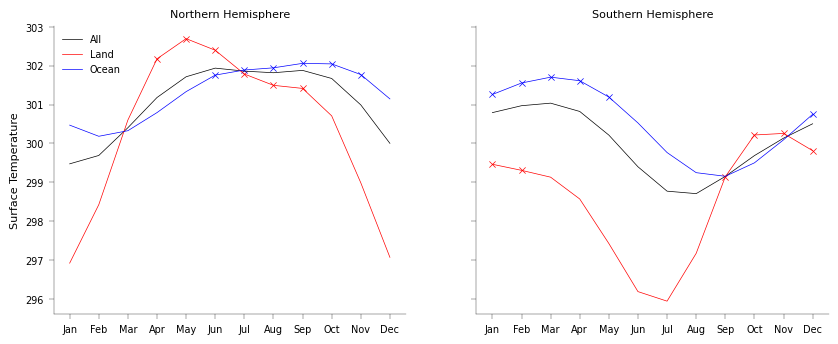

In [144]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig_resize(fig, 10)
# temp_month_avg_nh.weighted(weight_nh).mean(dim=['lat', 'lon']).plot(ax=ax[0])
ax[0].plot(temp_month_avg_nh.month, temp_month_avg_nh.weighted(weight_nh).mean(dim=['lat', 'lon']), 
           color='k', label='All')
ax[0].plot(temp_month_avg_nh.month, temp_nh_land, 
           color='r', label='Land')
ax[0].scatter(nh_land_summer_months, temp_nh_land.sel(month=nh_land_summer_months), 
           color='r', marker='x', s=20)
ax[0].plot(temp_month_avg_nh.month, temp_nh_ocean, 
           color='b', label='Ocean')
ax[0].scatter(nh_ocean_summer_months, temp_nh_ocean.sel(month=nh_ocean_summer_months), 
              color='b', marker='x', s=20)

ax[1].plot(temp_month_avg_sh.month, temp_month_avg_sh.weighted(weight_sh).mean(dim=['lat', 'lon']), 
           color='k', label='All')
ax[1].plot(temp_month_avg_sh.month, temp_sh_land, 
           color='r', label='Land')
ax[1].scatter(sh_land_summer_months, temp_sh_land.sel(month=sh_land_summer_months), 
           color='r', marker='x', s=20)
ax[1].plot(temp_month_avg_sh.month, temp_sh_ocean, 
           color='b', label='Ocean')
ax[1].scatter(sh_ocean_summer_months, temp_sh_ocean.sel(month=sh_ocean_summer_months), 
              color='b', marker='x', s=20)
ax[0].legend()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(1, 13), labels=months)
ax[0].set_ylabel('Surface Temperature')
ax[0].set_title('Northern Hemisphere')
ax[1].set_title('Southern Hemisphere')
plt.show()
# savefig(fig, os.path.join(os.getcwd(), 'temp_month.pdf'))